# Homework 3: Sequence Identification Problem <15 points in total>

## Introduction
In class, we saw an example of how to use deep learning with the `Keras` package to discover binding motif in DNA. In this practice problem, we will practice using `PyTorch` to implement a neural network that can identify a binding motif. 


We will first use our model to predict whether or not a given DNA sequence has a transcriptor-factor binding site. 

`dna_sequence.txt` stores the dna sequences which have a uniform length of 50.

`labels.txt` stores the corresponding labels of the dna sequences. 1 represents that the sequence has the binding motif, and 0 represents that the sequence doesn't have the binding motif.

Our goal is to train a neural network that can predict whether or not the given DNA sequence contains the motif of a transcriptor-factor binding site.

Next, we will try to interpret the trained model to understand what pattern the model is trying to identify. 


## What needs to be done-

#### Task 1. Complete the code for `task1` and train the model <10 points>

Validation accuracy will have to be above 90% to get full credit


#### Task 2. Interpret the model and find the motif <5 points>
Identify the motif and write it in the notebook



##### <font color='Red'>For this programming problem, you only need to submit the code (notebook with the output displayed and the answer for task2) on gradescope. You don't need to write anything on the assignment PDF file</font>
</font>


## Environmet

To run this code, you may have to install `numpy`, `torch`, `sckikit-learn`, `pandas`, and `matplotlib`, if you haven't done so and are running locally.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Read in the data
First, let's read in the dna sequence data and its labels.

In [ ]:
!wget https://www.dropbox.com/s/xz1jdg4z7bmx69g/dna_sequence.txt?dl=1 -O dna_sequence.txt
!wget https://www.dropbox.com/s/gyd0k1kv7wfefjf/labels.txt?dl=1 -O labels.txt

--2023-04-06 20:59:00--  https://www.dropbox.com/s/xz1jdg4z7bmx69g/dna_sequence.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/xz1jdg4z7bmx69g/dna_sequence.txt [following]
--2023-04-06 20:59:01--  https://www.dropbox.com/s/dl/xz1jdg4z7bmx69g/dna_sequence.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc14f556c8407c10a231efc33be6.dl.dropboxusercontent.com/cd/0/get/B5rl5UgFn1gDvE7pFm7cm0EO8-HrDguY0rHp42_PYSESYBGIqcxpk4JAyugIuL8bK8TGrsjzsL5i1EDW9bChmCbhwhTappqfsZdn4x8CFWs6c6K3TXDWcpblOW2P7dPiuReijs_uzrZtxBMrJHwfnOEwV9YI7vmwXsw3ybjiVUJl1pglqTeQDVT6lwvOFKg8bjE/file?dl=1# [following]
--2023-04-06 20:59:01--  https://uc14f556c8407c10a231efc33be6.dl.dropboxusercontent.com/cd/0/get/B5rl5UgFn1gDvE7pFm7cm0EO8-HrDguY0rHp42_PYS

In [ ]:
seqs = pd.read_csv("dna_sequence.txt", sep = "\t", header = None).to_numpy()
labels = pd.read_csv("labels.txt", sep = "\t", header = None).to_numpy()

In [ ]:
seqs

array([['TACTAGTATTCTCCGCACATCAACTGGAATTCTACCGGTTTTTGTCCGGT'],
       ['CGCTACAGTCCCGTACTTAACTCTTTGATCTCGTATTCAAAAACGATTGC'],
       ['CACCCCTGGGGTTACAGCTATCATCACCATCATGGTACAGTTCCCACCCG'],
       ...,
       ['TCGTTCCACTTAGCCAGATGTAAGTAGCACTATACAGTCCCGTACTATCT'],
       ['GGGGACTGCGATCCTTCTTTCGCGACCACGTCAGTACATTTGTTATAGTC'],
       ['TGAAGTCCCGTACTCGATTGCCACGGCTTTTACTCAATATACCTGCACGG']],
      dtype=object)

In [ ]:
labels

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

## Preprocessing the dataset
In order to enable the models to read the data, we need to transform the sequences into a machine readable format. Here, we are using one-hot encoding for the sequence data.

In [ ]:
def OneHotEncoding(sequences):
  integer_encoder = LabelEncoder() 
  one_hot_encoder = OneHotEncoder(categories='auto')
  input_features = []
  for sequence in sequences:
    integer_encoded = integer_encoder.fit_transform(list(sequence[0]))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray().T)
  input_features = np.stack(input_features)      

  return input_features


input_features = OneHotEncoding(seqs)

print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',seqs[0])
print('One hot encoding of Sequence #1:\n',input_features[0])


Example sequence
-----------------------
DNA Sequence #1:
 ['TACTAGTATTCTCCGCACATCAACTGGAATTCTACCGGTTTTTGTCCGGT']
One hot encoding of Sequence #1:
 [[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0.
  0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  1. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0.
  0. 1.]]


Split the data into training and validating dataset, and transform them into tensors.

In [ ]:
train_features, val_features, train_labels, val_labels = train_test_split(
    input_features, labels, test_size=0.25, random_state=42)

train_labels = torch.as_tensor(train_labels)
train_features = torch.as_tensor(train_features)
val_features = torch.as_tensor(val_features)
val_labels = torch.as_tensor(val_labels)

In [ ]:
train_features.shape

torch.Size([1500, 4, 50])

In [ ]:
val_features.shape

torch.Size([500, 4, 50])

In [ ]:
train_labels.shape

torch.Size([1500, 1])

In [ ]:
val_labels.shape

torch.Size([500, 1])

In [ ]:
# val_features = val_features[:500,:,:]

In [ ]:
val_features.shape


torch.Size([500, 4, 50])

# Task 1: Design, train, and evaluate a convolutional neural network to classify the sequences

In this task, you will design a convolutional neural network to predict whether or not a given DNA sequence has a transcriptor-factor binding site. This is a binary classification problem. 

You will  train your model on the training set and evaluate your model on the validation set. 

In [ ]:
#TODO: implement a CNN model

class cnn(nn.Module): 
  def __init__(self):
    super(cnn,self).__init__()
    self.conv1 = nn.Conv1d(in_channels=4, out_channels=32, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(32* 12 * 2, 256)
    self.fc2 = nn.Linear(256, 1)
    self.dropout = nn.Dropout(p=0.5)
    self.sigmoid = nn.Sigmoid()
    
  def forward(self,x):
      x = self.conv1(x)
      x = nn.ReLU()(x)
      x = self.pool1(x)
      x = self.conv2(x)
      x = nn.ReLU()(x)
      x = self.pool2(x)
      x = x.view(-1, 32 * 12 * 2)
      x = self.fc1(x)
      x = nn.ReLU()(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.sigmoid(x)
      return x


In [ ]:
model = cnn()
print(model)

cnn(
  (conv1): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)


In [ ]:

#TODO: define the batch size 
batch_size = 15   # works with batch_size 1

#Put the dataset into a dataloader
train_ds = TensorDataset(train_features, train_labels)
val_ds = TensorDataset(val_features, val_labels)
trainLoader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valLoader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)


In [ ]:

#TODO: define the learning rate, loss function and optimizer
loss_fn = nn.BCELoss() #you can change this too based on the final layer of your model
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#TODO: complete the code to train and evaluate the model

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0

    for i, (X, y) in enumerate(dataloader):
        # TODO: Compute prediction and loss
        X, y = X.float(), y.float()
        pred = model(X)
        loss = loss_fn(pred, y)
        # TODO: complete backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        correct += (torch.round(pred) == y).type(torch.float).sum().item()
        train_loss += loss.item()
        if i % 5 == 0:
            loss, current = loss.item(), i * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    #calculate the average loss and accuracy in this epoch
    train_loss /= num_batches
    train_accuracy = correct / size
    return train_loss, train_accuracy

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.float(), y.float()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    test_accuracy = correct / size
    print(f"Validation: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    #calculate the average loss and accuracy in this epoch
    return test_loss, test_accuracy



In [ ]:
epochs = 10

train_losses, train_accs, test_losses, test_accs = [], [], [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss, acc = train(trainLoader, model, loss_fn, optimizer)
    train_losses.append(loss)
    train_accs.append(acc)

    loss, acc = test(valLoader, model, loss_fn)
    test_losses.append(loss)
    test_accs.append(acc)


print("Done!")

Epoch 1
-------------------------------
loss: 0.686802  [    0/ 1500]
loss: 0.711792  [   75/ 1500]
loss: 0.698858  [  150/ 1500]
loss: 0.724836  [  225/ 1500]
loss: 0.717459  [  300/ 1500]
loss: 0.703947  [  375/ 1500]
loss: 0.683195  [  450/ 1500]
loss: 0.674782  [  525/ 1500]
loss: 0.674933  [  600/ 1500]
loss: 0.672399  [  675/ 1500]
loss: 0.678253  [  750/ 1500]
loss: 0.662409  [  825/ 1500]
loss: 0.635098  [  900/ 1500]
loss: 0.689387  [  975/ 1500]
loss: 0.715168  [ 1050/ 1500]
loss: 0.780900  [ 1125/ 1500]
loss: 0.602033  [ 1200/ 1500]
loss: 0.632042  [ 1275/ 1500]
loss: 0.609814  [ 1350/ 1500]
loss: 0.609860  [ 1425/ 1500]
Validation: 
 Accuracy: 86.0%, Avg loss: 0.591136 

Epoch 2
-------------------------------
loss: 0.594330  [    0/ 1500]
loss: 0.538005  [   75/ 1500]
loss: 0.658542  [  150/ 1500]
loss: 0.670635  [  225/ 1500]
loss: 0.411990  [  300/ 1500]
loss: 0.357009  [  375/ 1500]
loss: 0.348744  [  450/ 1500]
loss: 0.299668  [  525/ 1500]
loss: 0.268955  [  600/ 1500

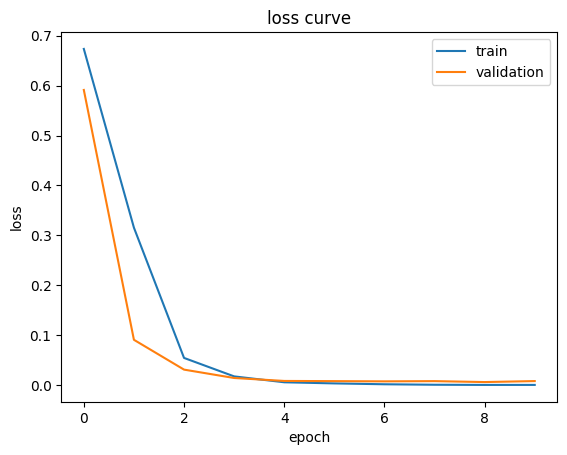

In [ ]:
#plot loss
plt.figure()
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('loss curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

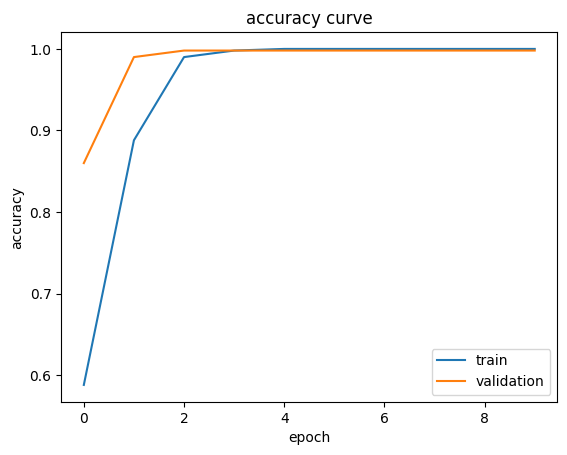

In [ ]:
#plot accuracy

plt.figure()
plt.plot(train_accs)
plt.plot(test_accs)
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:

print(val_features.shape)
print(torch.round(val_features.float()).shape)
print(val_labels.float().shape)

torch.Size([500, 4, 50])
torch.Size([500, 4, 50])
torch.Size([500, 1])


Confusion matrix:
 [[255   1]
 [  0 244]]


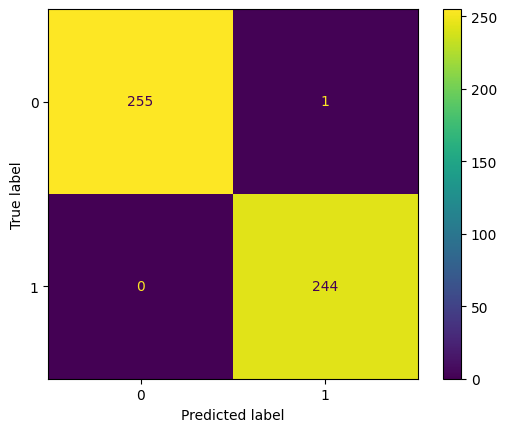

In [ ]:

#visualization of confusion matrix

model.eval()
#val_features[:1, :, :]
predicted_labels = torch.round(model(val_features.float())).detach().numpy() #you can change this based on the final layer of your model
true_labels = val_labels
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion matrix:\n',cm)


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

# Task 2: Model Interpretation

Now, after we have trained the model, we are curious about what motif the model identifies. We will use `captum`, a library for model interpretation to understand the importance of each DNA base on the predictions. 

`captum` is not pre-installed on google colab, so you will need to first install it with the following command. If you are running on your local computer, you can also install it with other environment management systems you like.

##### <font color='Red'> Execute the code below and answer the question below in this cell.</font>

Question: Assuming we know that our motif has a length of 11. Can you guess what the motif is? 

Answer: <TODO:  GTCCCGTAC


In [ ]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.1 MB/s eta 0:00:00


In [ ]:
from captum.attr import IntegratedGradients


Let's take a postive sample in the DNA sequences to understand how our model predicts its labels.

In [ ]:
sample_seq = seqs[1]
sample_label = labels[1]
print(f'our example sequence is: {sample_seq.item(0)}, the label is: {sample_label}')

our example sequence is: CGCTACAGTCCCGTACTTAACTCTTTGATCTCGTATTCAAAAACGATTGC, the label is: [1]


In [ ]:
#transform the sequence data into one-hot encoding tensor
sample_features = OneHotEncoding(list([sample_seq]))
sample_features = torch.tensor(sample_features).float()
print(sample_features.shape)

torch.Size([1, 4, 50])


***Integrated Gradients*** from the Captum library assigns an importance score to each input feature by approximating the integral of the gradients of the model’s output with respect to the inputs.
See: https://pytorch.org/tutorials/beginner/introyt/captumyt.html for more information


In [ ]:
#Calculate the importance scores for the model
model.eval()
integrated_gradients = IntegratedGradients(model)
ig = integrated_gradients.attribute(sample_features)
ig = torch.mean(ig, dim=1)

Text(0.5, 1.0, 'Importance Scores for bases in one of the positive sequences')

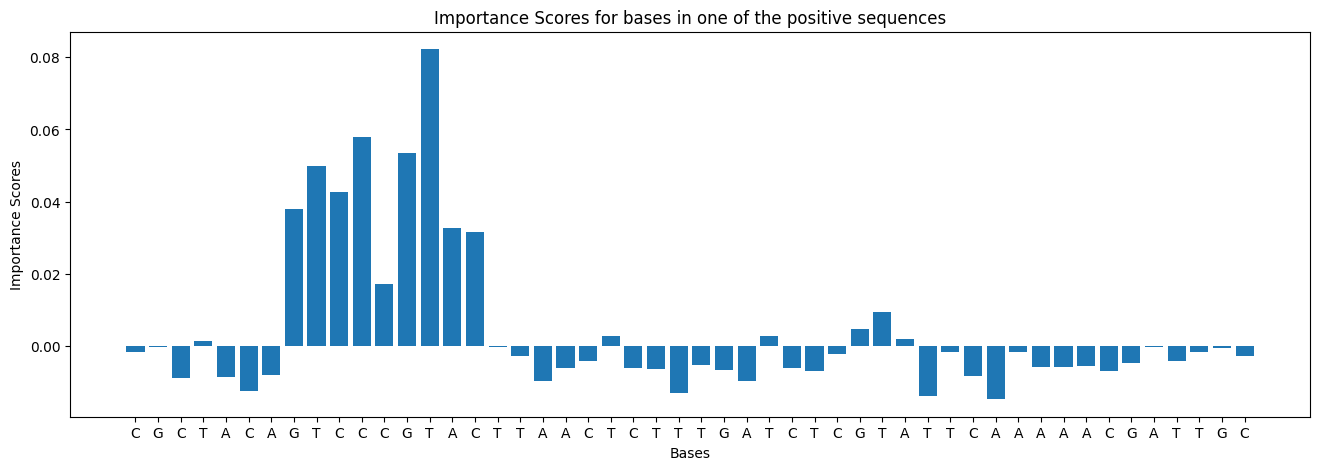

In [ ]:
#plot the importance scores
plt.figure(figsize=[16,5])

bases = seqs[1][0]
igs = ig.flatten().tolist()


plt.bar(range(len(bases)), igs)
plt.xticks(range(len(bases)), bases)

plt.xlabel('Bases')
plt.ylabel('Importance Scores')

plt.title('Importance Scores for bases in one of the positive sequences')

## Submission

For this problem, you will need to save the notebook with the outputs and answer (for Task2) and upload it onto gradescope.

Don't forget to write you answer for Task 2 in the notebook cell!

In [ ]:
pip install Bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.3 MB/s eta 0:00:00


In [ ]:
import Bio
from Bio.Seq import Seq
from Bio import motifs

In [ ]:
instances = [Seq("GTCCCGTACGT")]
m = motifs.create(instances)
print(len(m))

11


In [ ]:
print(m)

GTCCCGTACGT

